## 1 Why PyCall?

* 1.1 Call Python functions. Types get automatic conversion between Julia & Python
* 1.2 Import Python modules and submodules to use in Julia
* 1.3 Define Python classes using Julia syntax
* 1.4 Share large data structures between Julia and Python, without copying them

## 2 Installation

- 2.1a `Pkg.add("PyCall")` for the release version
- 2.1b `Pkg.checkout("PyCall"); Pkg.build("PyCall")` for the development version

    If Python is on the path, PyCall will use it by default. 
    If Python is not on the path, the package, Conda.jl will be installed as well. Conda.jl will add Miniconda - a minimal Python distribution, local only to Julia, not to the system.
    

- 2.2 To switch to another Python version:

    `ENV["PYTHON"] = ".. path to the new Python .."; Pkg.build("PyCall")`
    
    
- 2.3 To switch to another Python version in a virtualenv:

    `rm(Pkg.dir("PyCall","deps","PYTHON")); Pkg.build("PyCall")`

## 3 Usage

In [11]:
using PyCall

In [2]:
# Julia Version
VERSION

v"0.5.0"

In [3]:
# Python version
readstring(`python -V`)

Python 2.7.11 :: Anaconda custom (64-bit)


""

### 3.1 Types that are convertible

- Numbers (integer, real, complex)
- Booleans
- Strings
- IO Streams
- Dates/Periods
- Functions
- Tuples
- Arrays/Lists

In [4]:
# NOT USED, BUT KEEP
arr = Array{Int}([1,2,3,2])
str = "hello, world!"
ios = open("chess_moves.txt", "r")
d = DateTime(2016,11,14,16,45)
funcArr = Array{Function}([max, min, sum, sort!])

4-element Array{Function,1}:
 max  
 min  
 sum  
 sort!

### 3.2 @pyimport - Importing modules & submodules

In [5]:
# using PyCall
@pyimport pandas_datareader.data as pdrd
stocks = ["GLD", "TLT", "XHB", "XLB", "XLE", "XLF", "XLU", "XLV"]  
# gold, long bond, home builders, materials, energy, finance, utilities, health
df = pdrd.get_data_yahoo(stocks, "01/01/2010", interval="m")

# pdd is an identifier/alias for the submodule. It is not an object. So use dot notation to access functions in the module.
# df is a Julia object of type PyObject
# Julia arrays are column-major. Python arrays are row-major. So indices will be reversed

PyObject <class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 83 (major_axis) x 8 (minor_axis)
Items axis: Open to Adj Close
Major_axis axis: 2010-01-04 00:00:00 to 2016-11-01 00:00:00
Minor_axis axis: GLD to XLV

  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
in show at C:\Users\Rock\.julia\v0.5\PyCall\src\PyCall.jl
  likely near C:\Users\Rock\.julia\v0.5\IJulia\src\kernel.jl:31
in show at C:\Users\Rock\.julia\v0.5\PyCall\sr

In [6]:
# Get only the closing price (index = 6) from the dataframe
# To extract a numpy array from a pandas dataframe, df.values. Why is it not df[:values]()?
# http://pandas.pydata.org/pandas-docs/stable/api.html#attributes-and-underlying-data
df_jArr = df[:values][6,:,:]
# Because of automatic conversion, df_jArr is a Julia Array, not a PyObject

83×8 Array{Float64,2}:
 105.96   75.1299  14.2412  25.7688  47.4117  10.1704   22.8306  27.8283
 109.43   74.8726  14.9952  26.9316  48.8384  10.5291   22.5291  27.935 
 108.95   73.3322  15.8811  29.0635  50.2142  11.466    23.1353  28.6801
 115.36   75.7682  18.0339  29.1235  52.3006  11.617    23.7437  27.5644
 118.88   79.6387  16.2588  26.3474  46.3119  10.5531   22.4333  25.7702
 121.68   84.256   13.5477  24.4156  43.5677   9.9485   22.2758  25.3001
 115.49   83.4586  14.2573  27.5482  47.2159  10.5968   23.939   25.632 
 122.08   90.4616  13.3869  26.7134  44.9007   9.76841  24.2858  25.2103
 127.91   88.1816  14.9816  28.785   49.3888  10.3607   24.9888  27.4952
 132.62   84.2405  14.6971  30.5588  52.1903  10.5124   25.2596  28.1084
 135.42   82.8175  14.8299  30.9013  55.2474  10.4402   24.4951  27.2968
 138.72   79.754   16.7229  34.0031  60.3956  11.5577   25.2549  28.5534
 129.87   77.2966  17.0113  34.0297  64.7317  11.8838   25.5612  28.7165
   ⋮                        

### 3.3a `convert(T, o::PyObject)` - Explicitly convert a PyObject into a known Julia type T

In [7]:
@pyimport pandas as pd
# The attribute pd.axes returns labels/column names of a pandas dataframe pd
axesNames = df[:axes]
ohlcva = convert(Array{String}, axesNames[1])
dates = convert(Array{Date}, axesNames[2])
etfSymbols = convert(Array{String}, axesNames[3])

8-element Array{String,1}:
 "GLD"
 "TLT"
 "XHB"
 "XLB"
 "XLE"
 "XLF"
 "XLU"
 "XLV"

In [8]:
# axesNames is a Julia Array{Array} (not a PyObject) due to automatic conversion
typeof(axesNames)

Array{Any,1}

### 3.3b `pyo["attribute"]` Vs `pyo[:attribute]` - Return a PyObject, even if auto-conv to a Julia type is possible

In [9]:
# To return the axes labels as a PyObject, instead of a Julia array
axesNames_pyo = df["axes"]

PyObject [Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close'], dtype='object'), DatetimeIndex(['2010-01-04', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-03', '2010-06-01', '2010-07-01', '2010-08-02',
               '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01',
               '2011-01-03', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-02', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-03', '2011-11-01', '2011-12-01',
               '2012-01-03', '2012-02-01', '2012-03-01', '2012-04-02',
               '2012-05-01', '2012-06-01', '2012-07-02', '2012-08-01',
               '2012-09-04', '2012-10-01', '2012-11-01', '2012-12-03',
               '2013-01-02', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-03', '2013-07-01', '2013-08-01',
               '2013-09-03', '2013-10-01', '2013-11-01', '2013-12-02',
               '2014-01-02', '2014-02-03', '2014-03-

In [30]:
# Return the number of axes. Python "special methods"
axesNames_pyo[:__len__]()

3

### 3.3c `pyeval(s::String, rType=PyAny; args)` - Evaluate a Python expression

In [31]:
# The string is a Python expression. So the index is zero-based
# Return the number of etfSymbol labels
pyeval("len(x[2])", PyAny; x=axesNames_pyo)

8

### 3.3d `get(pyo, pyIndex)` and `get(pyo, key)` instead of pyo[pyIndex] and pyo[key]. Zero-based index! Useful for working with Python classes

In [32]:
get(axesNames_pyo, 2)

PyObject Index([u'GLD', u'TLT', u'XHB', u'XLB', u'XLE', u'XLF', u'XLU', u'XLV'], dtype='object')

### 3.3e `PyReverseDims(jArr)` to pass a Julia Array to a Python package as a numpy array, while preserving its shape

In [28]:
# Julia arrays are column-major order
jArr = convert(Array{Int}, reshape(1:10, 5, 2))

5×2 Array{Int64,2}:
 1   6
 2   7
 3   8
 4   9
 5  10

In [16]:
# Python is row-major order
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html
@pyimport numpy as np
a = PyObject(np.array(1:10))
jpyArr = a[:reshape](5,2)  # uses the Python reshape method for an ndarray object (not Julia's reshape function)

5×2 Array{Int32,2}:
 1   2
 3   4
 5   6
 7   8
 9  10

In [34]:
# Row Sum of the original jArr
np.sum(PyReverseDims(jArr), 0)

5-element Array{Int64,1}:
  7
  9
 11
 13
 15

In [35]:
# The Julia array will have its dimensions reversed when passed to a Python function
np.sum(jArr, 0)

2-element Array{Int64,1}:
 15
 40

In [34]:
# Correlation between all pairs of ETFs
adjClose_pyo = pd.DataFrame(data=df_jArr, columns=etfSymbols)
corr = adjClose_pyo[:corr]()

,GLD,TLT,XHB,XLB,XLE,XLF,XLU,XLV
GLD,1.000000,-0.164734,-0.497103,-0.481577,-0.076149,-0.661889,-0.433625,-0.588517
TLT,-0.164734,1.000000,0.771685,0.695957,0.296021,0.712312,0.904920,0.816394
XHB,-0.497103,0.771685,1.000000,0.905087,0.612765,0.939945,0.893452,0.945071
XLB,-0.481577,0.695957,0.905087,1.000000,0.734482,0.946948,0.890505,0.932476
XLE,-0.076149,0.296021,0.612765,0.734482,1.000000,0.559293,0.471724,0.510033
XLF,-0.661889,0.712312,0.939945,0.946948,0.559293,1.000000,0.912421,0.975894
XLU,-0.433625,0.904920,0.893452,0.890505,0.471724,0.912421,1.000000,0.955008
XLV,-0.588517,0.816394,0.945071,0.932476,0.510033,0.975894,0.955008,1.000000


In [35]:
typeof(corr)

PyCall.PyObject

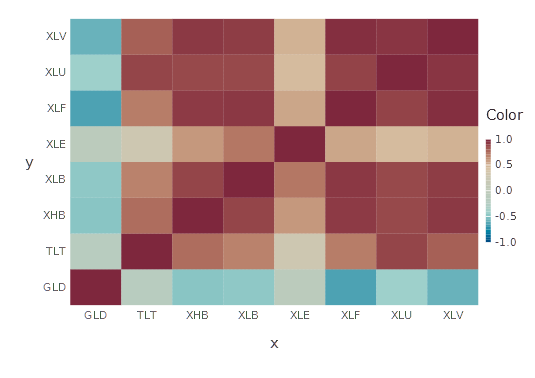

In [37]:
# Plot the correlation heatmap
using Gadfly  

n = length(etfSymbols)
x = Array(String, n^2)
y = Array(String, n^2)
color = Array(Float64, n^2)

z = corr[:values]

t = 0
for i in 1:n
    for j in 1:n  # i:n
        t += 1
        x[t] = etfSymbols[i]
        y[t] = etfSymbols[j]  # [n-j+1]
        color[t] = z[i,j]
    end
end

Gadfly.plot(x=x, y=y, color=color, Geom.rectbin)

## 3.4 pyArray, pyVector, PyDict, PyTextIO, PyAny

In [ ]:
# Chess Example (EXPAND THIS)

## 3.5 Creating Python Classes

In [67]:
@pydef type Student
    # Why not declare the type? ie courses=Dict{String,Int64}(). Python dictionaries are not typed
    __init__(self, name::String, id::Int64, courses=Dict()) =
    (self[:name] = name;
    self[:id] = id;
    self[:courses] = courses)
    addCourse(self, c::String) = push!(self[:courses], c=>0)
    updateScore(self, c::String, newScore::Int64) = set!(self["courses"], c, newScore)
    # ["courses"] will return a PyObject; [:courses] will return a Julia dictionary due to automatic conversion
end

PyObject <class 'Student'>

In [68]:
# Create a new Student, identified as john
john = Student("John", 123)

PyObject <Student object at 0x000000002E36A390>

In [69]:
john[:addCourse]("History")

Dict{Any,Any} with 1 entry:
  "History" => 0

In [70]:
john[:updateScore]("History", 85)

85

In [71]:
# In Julia, the key type and value type my matter. 
convert(Dict{String, Int64}, john["courses"])

Dict{String,Int64} with 1 entry:
  "History" => 85

## 4 Pandas (Julia Package)

## 5 NPZ - Saving numpy arrays